Investigating Impact of Constraints on Optimisation of Offline BTS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib ipympl

**Without** any constraints on the beam trajectory:

In [8]:
pth = Path('EI-no-constraints-10-samples-90-steps')
dfs = [pd.read_csv(csv) for csv in pth.glob('*.csv')]

(1.0, 6.0)

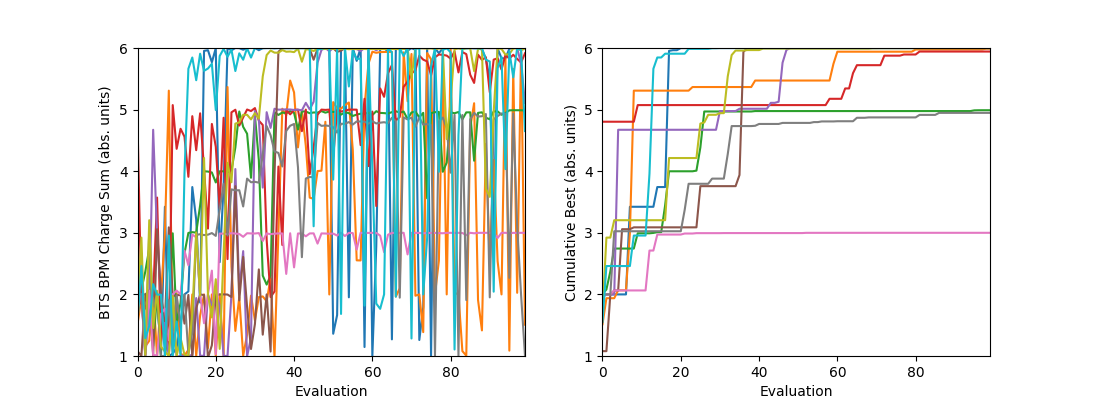

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (11, 4))
numEvals = 100
for df in dfs:
    ax[0].plot(range(numEvals), df.iloc[:, -3])
    ax[1].plot(range(numEvals), np.maximum.accumulate(df.iloc[:, -3]))
ax[0].set_xlabel('Evaluation')
ax[0].set_ylabel('BTS BPM Charge Sum (abs. units)')
ax[0].set_xlim(0, 99)
ax[0].set_ylim(1, 6)
ax[1].set_xlabel('Evaluation')
ax[1].set_ylabel('Cumulative Best (abs. units)')
ax[1].set_xlim(0, 99)
ax[1].set_ylim(1, 6)

**With** constraints on beam trajectory included:

A look at how the trajectory ends up with constraints.

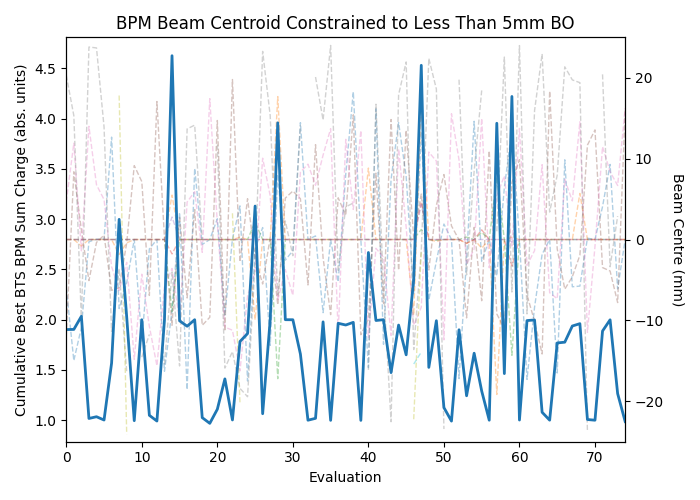

In [84]:
df = pd.read_csv(Path('..') / '2026-02-15__13-55-59.csv')
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
numDecisions = 14
numConstraints = 12
numObservables = 12
evals = df.shape[0]
ax.plot(range(evals), df.iloc[:, numDecisions], zorder = 1, lw = 2, label = 'BTS Sum Charge')
# ax.set_xlim(0, df.shape[0] - 1)
ax.set_xlabel('Evaluation')
ax.set_ylabel('Cumulative Best BTS BPM Sum Charge (abs. units)')
ax2 = ax.twinx()
ax.set_zorder(ax2.get_zorder() + 1)
ax.patch.set_visible(False)
ax2.set_ylabel('Beam Centre (mm)', rotation = 270, labelpad = 15)
# filter the observables to replace nans with large negative numbers to prevent accumulate not working as a NaN is invalid
for idx in range(numObservables):
    result = df.iloc[:, numDecisions + numConstraints + idx + 1] * 1e3
    ax2.plot(range(evals), result, label = f'BPM-{' '.join(df.columns[idx].split()[1:2])}', ls = '--', lw = 1, alpha = .35)
ax.set_xlim(0, 74)
ax2.set_ylim(-25, 25)
ax.set_title('BPM Beam Centroid Constrained to Less Than 5mm BO')
fig.tight_layout()


A look at how the trajectory ends up without constraints.

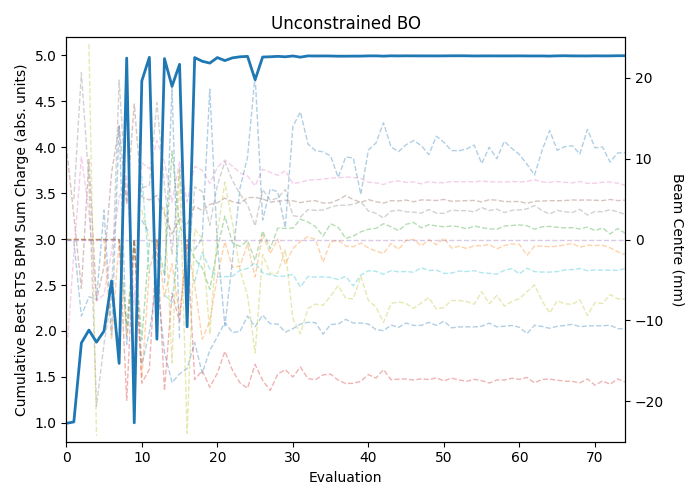

In [75]:
df = pd.read_csv(Path('..') / '2026-02-15__13-53-13.csv')
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
numDecisions = 14
numConstraints = 0
numObservables = 12
evals = df.shape[0]
ax.plot(range(evals), df.iloc[:, numDecisions], zorder = 1, lw = 2, label = 'BTS Sum Charge')
# ax.set_xlim(0, df.shape[0] - 1)
ax.set_xlabel('Evaluation')
ax.set_ylabel('Cumulative Best BTS BPM Sum Charge (abs. units)')
ax2 = ax.twinx()
ax.set_zorder(ax2.get_zorder() + 1)
ax.patch.set_visible(False)
ax2.set_ylabel('Beam Centre (mm)', rotation = 270, labelpad = 15)
# filter the observables to replace nans with large negative numbers to prevent accumulate not working as a NaN is invalid
for idx in range(numObservables):
    result = df.iloc[:, numDecisions + numConstraints + idx + 1] * 1e3
    ax2.plot(range(evals), result, label = f'BPM-{' '.join(df.columns[idx].split()[1:2])}', ls = '--', lw = 1, alpha = .35)
ax.set_xlim(0, 74)
ax2.set_ylim(-25, 25)
ax.set_title('Unconstrained BO')
fig.tight_layout()


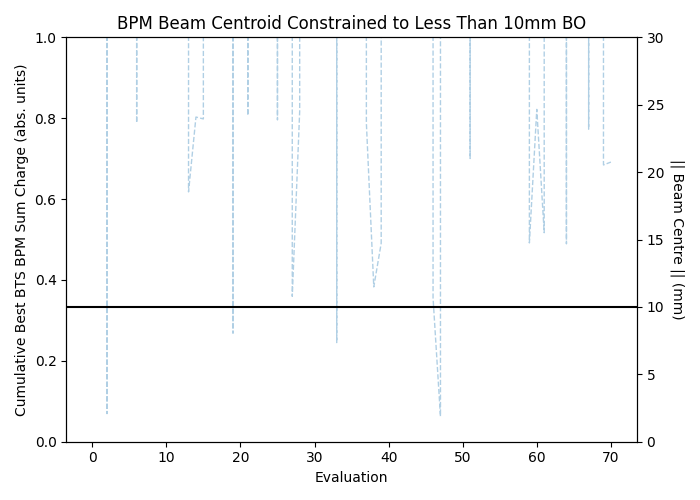

In [192]:
df = pd.read_csv(Path('..') / '2026-02-16__10-51-47.csv')
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
numDecisions = 14
numConstraints = 12
numObservables = 0
evals = df.shape[0]
# ax.plot(range(evals), df.iloc[:, numDecisions], zorder = 1, lw = 2, label = 'BTS Sum Charge')
# ax.set_xlim(0, df.shape[0] - 1)
ax.set_xlabel('Evaluation')
ax.set_ylabel('Cumulative Best BTS BPM Sum Charge (abs. units)')
ax2 = ax.twinx()
ax.set_zorder(ax2.get_zorder() + 1)
ax.patch.set_visible(False)
ax2.set_ylabel('|| Beam Centre || (mm)', rotation = 270, labelpad = 15)
# filter the observables to replace nans with large negative numbers to prevent accumulate not working as a NaN is invalid
for idx in range(numConstraints):
    if idx != 5:
        continue
    result = df.iloc[:, numDecisions + idx + 1] * 1e3
    ax2.plot(range(evals), result, label = f'BPM-{' '.join(df.columns[idx].split()[1:2])}', ls = '--', lw = 1, alpha = .35)
# ax.set_xlim(0, 74)
ax2.set_ylim(0, 30)
ax2.axhline(10, color = 'black')
ax.set_title('BPM Beam Centroid Constrained to Less Than 10mm BO')
fig.tight_layout()


The optimiser struggles to reduce the trajectory size at BPM pair 5 in the BTS - suggests a larger Beta function.

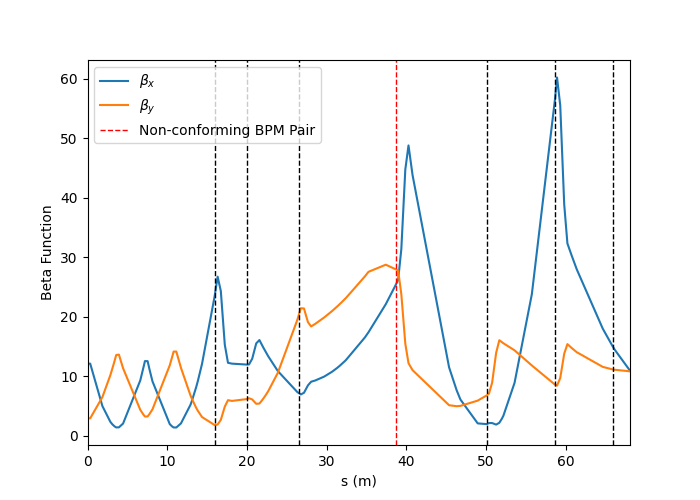

In [44]:
import at
lattice = at.load_mat(Path('..') / '..' / 'lattice-saves' / 'misaligned-bts-quads-correctors-100um-stddev-roll-100urad-stddev.mat')
s = np.zeros(len(lattice))
tot = 0
for idx, elem in enumerate(lattice):
    s[idx] = tot
    tot += elem.Length
_, _, lindata = at.linopt6(lattice, refpts = range(len(lattice)), twiss_in = {'beta': [12.13, 2.94], 'alpha': [-2.92, .75]})
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(s, lindata.beta[:, 0], label = r'$\beta_x$')
ax.plot(s, lindata.beta[:, 1], label = r'$\beta_y$')

# plot BPM locations
count = 0
for idx, element in enumerate(lattice):
    if element.FamName == 'BPM':
        count += 1
        if count != 4:
            ax.axvline(s[idx], ls = '--', color = 'black', lw = 1)
        else:
            ax.axvline(s[idx], ls = '--', color = 'red', lw = 1, label = 'Non-conforming BPM Pair')

ax.set_xlabel('s (m)')
ax.set_ylabel('Beta Function')
ax.set_xlim(0, s[-1])
ax.legend()